In [1]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la

In [11]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

# SymPT Mask

In [2]:
def letter(num):
    # Define the patterns for each letter
    patterns = {
        0: np.array([
            [1, 1, 1],
            [1, 0, 0],
            [1, 1, 1],
            [0, 0, 1],
            [1, 1, 1]
        ]),  # Capital "S"
        1: np.array([
            [0, 0, 0, 0],
            [1, 0, 0, 1],
            [0, 1, 1, 1],
            [0, 0, 0, 1],
            [1, 1, 1, 1]
        ]),  # Lowercase "y"
       2: np.array([
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [1, 1, 0, 1, 1],
            [1, 0, 1, 0, 1],
            [1, 0, 0, 0, 1]
        ]), # Lowercase "m"
        3: np.array([
            [1, 1, 1],
            [1, 0, 1],
            [1, 1, 1],
            [1, 0, 0],
            [1, 0, 0]
        ]),  # Capital "P"
        4: np.array([
            [1, 1, 1],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0]
        ]),  # Capital "T"
        }

    # Return the correct pattern or raise an error if the input is invalid
    if num in patterns:
        return patterns[num]
    else:
        raise ValueError("Input must be a number from 0 to 3.")
space = np.zeros((5,1))
zero_b = np.zeros((5,5)) 
last_pad = np.zeros((12,37))

(37, 37)

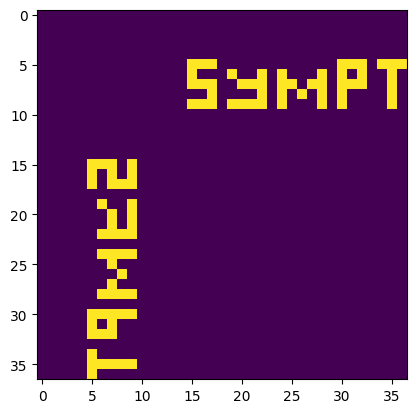

In [3]:
SymPT = np.block(
    [
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, letter(0),space,letter(1),space,letter(2),space,letter(3),space,letter(4)], 
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [last_pad]
    ]
)
SymPT = SymPT + SymPT.T
SymPT = SymPT
mask = Block(SymPT)
plt.imshow(SymPT)
SymPT.shape

# Hamiltonian

In [4]:
I = SymPT.shape[0]
J = SymPT.shape[1]
lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]


# finite = RDBasis("f", I)

H = sp.zeros(I, J)
lambda_index = 0
for i in range(I):
    for j in range(i, J):  # Loop only over upper triangular part (including diagonal)
        if i == j:
            H[i, j] = omegas[i]  # Diagonal elements
        else:
            H[i, j] = lambdas[lambda_index]
            H[j, i] = lambdas[lambda_index]  # Ensure symmetry
            lambda_index += 1

In [5]:
def substitution_rules(I, J):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas
values, omegas = substitution_rules(I,J)

In [6]:
Eff_Frame = EffectiveFrame(H, symbol_values = values)

Creating the EffectiveFrame object with matrix form.
The EffectiveFrame object has been initialized successfully.

Effective Frame

╭────────┬────────┬─────────────╮
│  Name  │  Type  │  Dimension  │
├────────┼────────┼─────────────┤
│ Finite │ Finite │    37x37    │
╰────────┴────────┴─────────────╯

Effective Hamiltonian: 	Not computed yet. To do so, run `solve` method. 




In [ ]:
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order = 3, method = "LA", mask=mask)
# Obtaining the result in the matrix form
result = Eff_Frame.get_H(return_form = "matrix")

# Comparing with ACE

In [ ]:
# Obtaining initial matrix
Hh = H.xreplace(values)
# Diagonalizing to obtain X unitary
X = Hh.diagonalize()[0]
X_inv = X.inv()

X = np.array(X, dtype=float)
X_inv = np.array(X_inv, dtype=float)

# Definining operator B(.) which has effect of block diagonalizing 
B_mask = lambda x: np.logical_not(SymPT)*1 * x

# Obtaining T operator
T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

# Final exact result
exact_result = la.inv(T) @ np.array(Hh, dtype=float) @ T

# Plotting

In [ ]:
diag_idx = np.diag_indices(SymPT.shape[0])
np_result = np.array(result).astype(float)
np_result[np.abs(np_result) == 0] = None
exact_result[np.abs(exact_result) == 0] = None

#fig, ax = plt.subplots(dpi = 100)
#mapp = ax.imshow(np_result, cmap = "inferno")
#fig.colorbar(mapp)
#plt.savefig(dir_images+'masked_hamiltonian.pdf',  bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

im = ax[0].imshow(np.array(Hh, dtype=float), cmap='inferno') # Initial Hamiltonian
fig.colorbar(im, ax=ax[0])
ax[0].set_title(r'$\mathcal{H}$', fontsize=20)

im = ax[1].imshow(exact_result.real, cmap='inferno') # Exact block diagonalization
fig.colorbar(im, ax=ax[1])
ax[1].set_title(r'$\tilde{\mathcal{H}}_{DV}$', fontsize=20)

im = ax[2].imshow(np_result, cmap='inferno') # Effective block diagonalization
fig.colorbar(im, ax=ax[2])
ax[2].set_title(r'$\tilde{\mathcal{H}}_{eff}$')

In [ ]:
for i in range(I):
    for j in range(J):
        if i == j:
            continue
        print(Hh[i, j] / np.abs(Hh[i,i] - Hh[j,j]))

# BOD for different orders

In [13]:
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order = 5, method = "BOD", mask=mask)
# Obtaining the result in the matrix form
result = Eff_Frame.get_H(return_form = "matrix")

Substituting the symbol values in the Hamiltonian and perturbative interactions.


Performing Block Diagonalization for each order: 100%|█| 5/5 [01:43<00:


The Hamiltonian has been solved successfully. Please use the get_H method to get the result in the desired form.


Converting to matrix form: 100%|███████| 1/1 [00:00<00:00, 3721.65it/s]


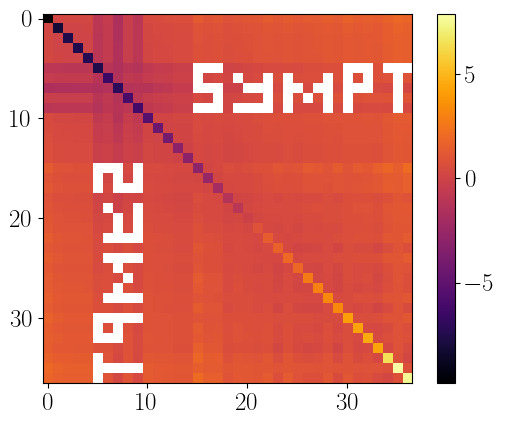

In [14]:
diag_idx = np.diag_indices(SymPT.shape[0])
np_result = np.array(result).astype(float)
plt_result = np_result.copy()
plt_result[np.abs(plt_result) == 0] = None

fig, ax = plt.subplots(dpi = 100)
mapp = ax.imshow(plt_result, cmap = "inferno")
fig.colorbar(mapp)
#plt.savefig(dir_images+'masked_hamiltonian.pdf',  bbox_inches='tight')

In [15]:
# Error function
def error(true_spect, eff_spect):
    diff =  eff_spect - true_spect 
    return np.abs(diff / true_spect)
# H0, H1, H2, H3, H4, H5 = [np.array(Hi, dtype = float) for Hi in list(Eff_Frame.corrections.values())]
true_spectrum = np.sort(np.array(H.xreplace(values).diagonalize()[1].diagonal()).astype(float)) # obtaining true spectrum (sorting for correct matching)
effe_spectrum = np.sort(np_result[diag_idx].astype(float)) 
err_not = error(true_spectrum, np.array(H.diagonal().xreplace(values)).astype(float))[0] # error of diagonal elements by doing nothing
err_eff = error(true_spectrum, effe_spectrum)[0] # error of effective spectrum

(-0.01, 0.3)

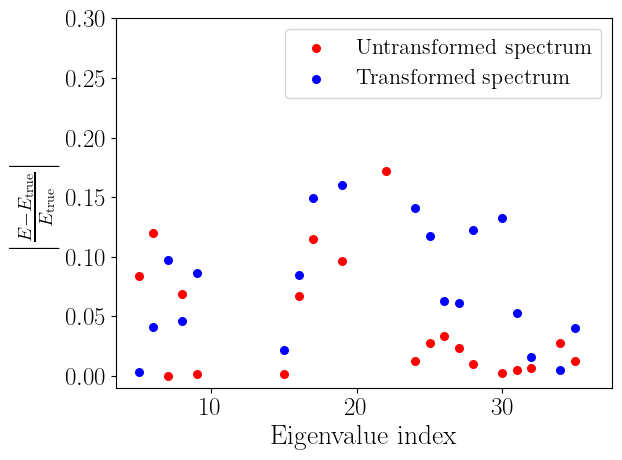

In [16]:
tmp1 = np.where(SymPT != 0)[0] # getting indices of mask
changed_diags = np.array(list(set(tmp1))) # getting indices of decoupled energies

fig, ax = plt.subplots(dpi = 100)
yes = True
for n, error in enumerate(err_not): 
    if n in changed_diags: # if plotting decoupled energy
        marker = "o"
        c = "r"
        ax.scatter(n, error, marker = marker, c = c, s = 30, label = r"$\mathrm{Untransformed}$ $\mathrm{spectrum}$" if yes else None)
        yes = False

yes = True  
for n, error in enumerate(err_eff): 
    if n in changed_diags: # if plotting decoupled energy
        marker = "o"
        c = "b"
        scatter = ax.scatter(n, error, marker = marker, c = c, s = 30, label = r"$\mathrm{Transformed}$ $\mathrm{spectrum}$" if yes else None)
        yes = False
        
ax.legend(fontsize=fntsize*0.8, loc=0)
ax.set_xlabel(r"$\mathrm{Eigenvalue}$ $\mathrm{index}$", fontsize = fntsize)
ax.set_ylabel(r"$\left|\frac{E - E_\mathrm{true}}{E_\mathrm{true}}\right|$", fontsize = fntsize)
ax.set_ylim(-0.01,0.3)
#fig.savefig(dir_images+'decoupled_energies_error.pdf',  bbox_inches='tight')